# MACS 40300: Problem Set #3
### By: Jesús Pacheco Vera

## 1. Matching the U.S. income distribution by GMM

In [1221]:
#%reset
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.optimize as opt
import numpy.linalg as lin

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1222]:
#Import the data
url = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS3/data/hh_inc_synth.txt')
resp = requests.get(url,allow_redirects=True)

open('hh_inc_synth.txt', 'wb').write(resp.content)
hhincome = np.loadtxt("hh_inc_synth.txt")
#hhincome

### Part a)

In [1223]:
#Create the brackets
brackets=np.append(np.arange(0, 200000, 5000).tolist(), [200000, 250000, 350000])

#Compute the weights
N = len(hhincome)
wg_200k = 1/(N*5000)
wg_250k = 1/(N*50000)
wg_250plus = 1/(N*100000)
first_bracket = (hhincome<200000)
second_bracket = (hhincome>=200000)*(hhincome<250000)
third_bracket = (hhincome>=250000)

weights = np.array([1/N] * N)
weights_graph = first_bracket*wg_200k + second_bracket*wg_250k + third_bracket*wg_250plus
#weights[weights < 1e-10] = 1e-10   #In case weights too close to zero cause conflicts on calculations
count, bins = np.histogram(hhincome, bins=brackets, weights=weights)

### Part b)

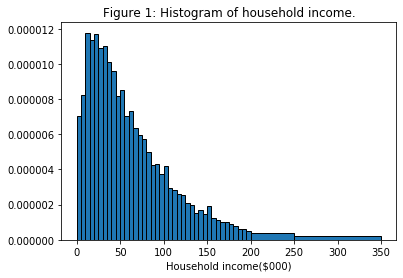

In [1224]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(hhincome, bins=brackets, edgecolor='black', density = False, weights=weights_graph)
#ticker, change scale of x-axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '%.0f' % (x * 1e-3)))
ax.set_title('Figure 1: Histogram of household income.')
_=ax.set_xlabel('Household income($000)')

I think this is the correct graph (a little different from the one in the pset3 pdf) because this are sums up to one. 

In [1225]:
n[0:-2].sum()*5000+(n[40]*50000)+(n[41]*100000)

0.9999999999984865

### Part c) Log-normal distribution

In [1226]:
import scipy.integrate as integr

def model_moments1(mu, sigma):
    lower_bounds=np.append(np.arange(1e-10, 200000, 5000).tolist(), [200000, 250000])
    upper_bounds=np.append(np.arange(5000, 200000, 5000).tolist(), [200000, 250000, 350000])
    bounds = np.column_stack((lower_bounds, upper_bounds))
    model_moms1 = np.zeros(42)

    for i in range(42):
        model_moms1[i] = sts.norm.cdf(np.log(bounds[i,1]), loc=mu, scale=sigma) -sts.norm.cdf(np.log(bounds[i,0]), loc=mu, scale=sigma)                                                               
        #The model moments are the area within each bracket (cdf in upper bound minus cdf in lower bound)
        
    model_moms1[40] = model_moms1[40]/10
    model_moms1[41] = model_moms1[41]/20
    return model_moms1

In [1227]:
def data_moments(xvals, weights_f = weights): 
    data_moms, _ = np.histogram(xvals, bins=brackets, weights=weights_f)
    return data_moms

In [1228]:
def errors(xvals, mu, sigma, simple=True):
    data_moms = np.array([data_moments(xvals)])
    model_moms1 = np.array([model_moments1(mu, sigma)])
     
    if simple:
        err_vec1 = model_moms1 - data_moms
    else:
        err_vec1 = (model_moms1 - data_moms) / data_moms
    return err_vec1

In [1229]:
#Criterion
def criterion(params, *args): 
    mu, sigma = params
    xvals, W = args
    err1 = errors(xvals, mu, sigma)
    crit_val1 = err1 @ W @ err1.T
    return crit_val1

Setting the initial guesses of mu and sigma as the log of the average and standard deviation respectively. 

In [1231]:
#MINIMIZATION
#Initial guesses
mu_init = np.log(np.mean(hhincome))
sigma_init = np.log(np.std(hhincome))
params_init1 = np.array([mu_init, sigma_init])

#W_0 = np.eye(42)
W_0 = np.diagflat(data_moments(hhincome))

gmm_args = (hhincome, W_0)
results = opt.minimize(criterion, params_init1, args=(gmm_args), method='L-BFGS-B', tol=1e-14)
mu_GMM, sig_GMM = results.x
print('mu_GMM=', mu_GMM, ' sig_GMM=', sig_GMM)
#results
print("The minimized criterion function", errors(hhincome, mu_GMM, sig_GMM) @ W_0 @ errors(hhincome, mu_GMM, sig_GMM).T)

mu_GMM= 10.890873136559456  sig_GMM= 1.0512036307452186
The minimized criterion function [[4.49610181e-05]]


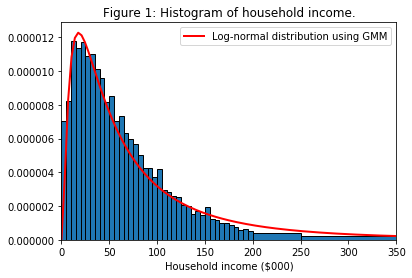

In [1232]:
def lognorm_pdf (xvals, mu, sigma):
    vals = (1/(xvals * sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    return vals

fig, ax = plt.subplots()
n, bins, patches = plt.hist(hhincome, bins=brackets, edgecolor='black', density = False, weights=weights_graph)

ax.set_title('Figure 1: Histogram of household income.')
ax.set_xlabel('Household income ($000)')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '%.0f' % (x * 1e-3)))
dist_pts = np.linspace(1, 3500000, 1000)

plt.plot(dist_pts, lognorm_pdf(dist_pts,mu_GMM, sig_GMM), linewidth=2, color='r', label='Log-normal distribution using GMM')
plt.legend(loc='upper right')
_=plt.xlim([0, 350000])

### Part d) Gamma distribution

In [1233]:
import math
import scipy.integrate as integr

def model_moments2(alpha, beta):
    lower_bounds=np.append(np.arange(1e-10, 200000, 5000).tolist(), [200000, 250000])
    upper_bounds=np.append(np.arange(5000, 200000, 5000).tolist(), [200000, 250000, 350000])
    bounds = np.column_stack((lower_bounds, upper_bounds))
    model_moms = np.zeros(42)
    
    gamma_pdf = lambda x: (1 / ((beta ** alpha) *  math.gamma(alpha))) * (x ** (alpha - 1)) * (np.exp(-(x/beta)))
    
    for i in range(42):
        (model_moms[i], _) = integr.quad(gamma_pdf, bounds[i,0], bounds[i,1])
    model_moms[40] = model_moms[40]/10
    model_moms[41] = model_moms[41]/20
    return model_moms

In [1234]:
def err_vec2(xvals, alpha, beta, simple=False):
    data_moms = np.array([data_moments(xvals)])
    model_moms = np.array([model_moments2(alpha, beta)])
    if simple:
        err_vec2 = model_moms - data_moms
    else:
        err_vec2 = (model_moms - data_moms) / data_moms
    
    return err_vec2

In [1235]:
def criterion2(params, *args):
    alpha, beta = params
    xvals, W = args
    err2 = err_vec2(xvals, alpha, beta, simple=False)
    crit_val2 = err2 @ W @ err2.T
    
    return crit_val2

In [1236]:
alpha_init = 3 
beta_init = 20000
params_init2 = np.array([alpha_init, beta_init])
W0 = np.diagflat(data_moments(hhincome))
#W0 = np.eye(42)
gmm_args2 = (hhincome, W0)
results_ga = opt.minimize(criterion2, params_init2, args=(gmm_args2), method='L-BFGS-B')
alpha_gmm, beta_gmm = results_ga.x
print("Alpha GMM: ", alpha_gmm)
print("Beta GMM: ", beta_gmm)
print("The minimized criterion function", err_vec2(hhincome, alpha_gmm, beta_gmm) @ W0 @ err_vec2(hhincome, alpha_gmm, beta_gmm).T)
#results_ga

Alpha GMM:  1.4058448540932567
Beta GMM:  45619.33610600618
The minimized criterion function [[0.04376397]]


Here's the histogram with the GMM estimated gamma distribution: 

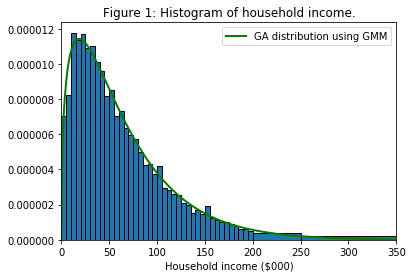

In [1239]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(hhincome, bins=brackets, edgecolor='black', density = False, weights=weights_graph)
ax.set_title('Figure 1: Histogram of household income.')
ax.set_xlabel('Household income ($000)')

dist_pts = np.linspace(1, 350000, 500)
def gamma_pdf(xvals, alpha, beta): 
    pdf_vals = (1 / ((beta ** alpha) *  math.gamma(alpha))) * (xvals ** (alpha - 1)) * (np.exp(-(xvals/beta)))
    return pdf_vals

plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_gmm, beta_gmm),
         linewidth=2, color='g', label='GA distribution using GMM')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '%.0f' % (x * 1e-3)))
plt.legend(loc='upper right')
_= plt.xlim([0, 350000])

### Part e) Comparing both estimations

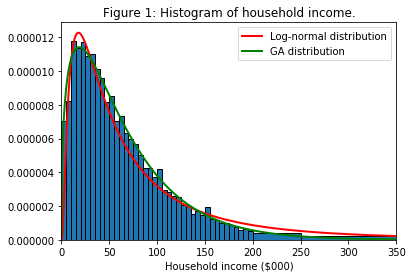

In [1240]:
fig, ax = plt.subplots()
n, bins, patches = plt.hist(hhincome, bins=brackets, edgecolor='black', density = False, weights=weights_graph)
ax.set_title('Figure 1: Histogram of household income.')
ax.set_xlabel('Household income ($000)')

plt.plot(dist_pts, lognorm_pdf(dist_pts,mu_GMM, sig_GMM), 
         linewidth=2, color='r', label='Log-normal distribution')

plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_gmm, beta_gmm),
         linewidth=2, color='g', label='GA distribution')

ax.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, pos: '%.0f' % (x * 1e-3)))
plt.legend(loc='upper right')
_= plt.xlim([0, 350000])

Both distributions fit the income data fairly well visually. It seems to me like the green line (GA) is estimating a bit better (the line seems closer to the edges of the bins) in the middle part of the distribution. The lower part of the distributions (the mode) is estimated somewhat similarly. The upper part of the distribution is definately better estimated by the gamma distribution.

### Part f) Two-step weighting matrix

The chunk of code that creates the error matrix takes some time, so I didn't do a function for it. It iterates over  the R moments and the N number of observations in the data to create a RxN error matrix. 

In [1241]:
model_moments = model_moments2(alpha_gmm, beta_gmm)
R = 42
N = len(hhincome)
Err_mat = np.zeros((R, N))

for j in range(0,R):
    for i in range(0,N):
        Err_mat[j,i] = data_moments(hhincome[i], weights_f=(1/N))[j] - model_moments[j]

print(Err_mat)

[[-0.03362538 -0.03362538 -0.03362538 ... -0.03362538 -0.03362538
  -0.03362538]
 [-0.05005342 -0.05005342 -0.05005342 ... -0.05005342 -0.05004516
  -0.05005342]
 [-0.05541149 -0.05541149 -0.05541149 ... -0.05541149 -0.05541149
  -0.05541149]
 ...
 [-0.00295246 -0.00295246 -0.00295246 ... -0.00295246 -0.00295246
  -0.00295246]
 [-0.00177403 -0.00177403 -0.00177403 ... -0.00177403 -0.00177403
  -0.00177403]
 [-0.00043746 -0.00043746 -0.00043746 ... -0.00043746 -0.00043746
  -0.00043746]]


In [1245]:
VCV2 = (1 / hhincome.shape[0]) * (Err_mat @ Err_mat.T)
W_2s = lin.inv(VCV2)

Now that I have the the two-step matrix, I run again the minimization problem in part d) with this matrix.

In [1247]:
#The minimization problem 
gmm_args3 = (hhincome, W_2s)
results_ga2 = opt.minimize(criterion2, params_init2, args=(gmm_args3), method='L-BFGS-B')
alpha_gmm2, beta_gmm2 = results_ga2.x
#results_ga2

The estimations of alpha and beta did not change significantly.

In [1248]:
print('With the matrix created with data moments, we have alpha =', alpha_gmm, ', and beta=', beta_gmm)
print('With the two-step weigthing matrix, we have alpha =', alpha_gmm2, ', and beta=', beta_gmm2)

With the matrix created with data moments, we have alpha = 1.4058448540932567 , and beta= 45619.33610600618
With the two-step weigthing matrix, we have alpha = 1.4124160385683346 , and beta= 44207.28169934738


## 2. Estimating the Brock and Mirman (1972) model by GMM

In [1249]:
#Read the MacroSeries.txt file
url_macro = ('https://raw.githubusercontent.com/jesuspachecov/StructEst_W20/' +
       'master/ProblemSets/PS3/data/MacroSeries.txt')
response = requests.get(url_macro,allow_redirects=True)

open('MacroSeries.txt', 'wb').write(response.content)
macroseries = np.loadtxt("MacroSeries.txt",
  # dtype={'names': ('ct', 'kt', 'wt', 'rt'),
   #       'formats': (np.float, np.float, np.float, np.float)},
   delimiter=',', skiprows=0)
#macroseries[1:10,]

### Part a)

Let's first create the 4 model moments as requested. Note that the data moments are just zeros. 

In [1250]:
def model_moments3(zt, kt, wt, ct, alpha, rho, mu, beta=1):
    zt_1 = np.append(mu, zt[:-1])
    zt_p1 = np.append(zt[+1:],zt[-1])
    ct_p1 = np.append(ct[+1:],ct[-1])
    kt_p1 = np.append(kt[+1:],kt[-1])
    
    m1 = np.mean(zt_1 - rho*zt - (1-rho)*mu)
    m2 = np.mean((zt_p1 - rho*zt - (1-rho)*mu)*zt)
    m3 = np.mean(beta*alpha*np.exp(zt_p1)*(kt_p1**(alpha-1))*(ct/ct_p1) - 1)
    m4 = np.mean((beta*alpha*np.exp(zt_p1)*(kt_p1**(alpha-1))*(ct/ct_p1) - 1)*wt)
    mod_moments3 = np.array([m1, m2, m3 ,m4])
    return mod_moments3

In [1251]:
def errors3(zt, kt, wt, ct, alpha, rho, mu, beta=1, simple=True):
    moms_data = np.array([0,0,0,0]) #DATA MOMENTS ARE JUST ZEROS!
    moms_model = np.array([model_moments3(zt, kt, wt, ct, alpha, rho, mu, beta=1)])
    if simple:
        err_vec3 = moms_model - moms_data
    else:
        err_vec3 = (moms_model - moms_data) / moms_data
    #We need to use the simple version because the data moments are zero (denominator)
    return err_vec3

In [1252]:
def crit3(params, *args):
    alpha, rho, mu = params
    kt, wt, ct, W = args
    
    #eq4
    zt = np.log(wt) - (np.log(1-alpha)+(alpha)*np.log(kt))
    
    err3 = errors3(zt, kt, wt, ct, alpha, rho, mu)
    crit_val3 = err3 @ W @ err3.T
    
    return crit_val3

For the initial guesses I will use the computations from the last problem set, where I assumed $\alpha = .5$ and computed $\rho$ and $\mu$ from a regression. 

In [1253]:
#Initial guesses and args
params_init3= np.array([0.5, 0.680047, 8.92559606]) 

ct = macroseries[:,0]
kt = macroseries[:,1]
wt = macroseries[:,2]
#rt = macroseries[:,3]   #rt not needed
W_I = np.eye(4)

macro_args = (kt, wt, ct, W_I)

#MINIMIZATION
results_macro = opt.minimize(crit3, params_init3, args=(macro_args), method='L-BFGS-B')
                       #tol=1e-14   #The minimization does not seem to converge when adjusting the tolerance
alpha2_gmm, rho_gmm, mu_gmm = results_macro.x

print ("Alpha:", alpha2_gmm)
print ("Rho:", rho_gmm)
print ("Mu:", mu_gmm)
m = errors3(np.log(wt) - (np.log(1-alpha2_gmm)+(alpha2_gmm)*np.log(kt)), kt, wt, ct, alpha2_gmm, rho_gmm, mu_gmm, beta=1, simple=True)
print ("Minimized criterion function: ", (m @ m.T)[0])

Alpha: 0.41753993930871885
Rho: 1.0107936588382918
Mu: 9.0235720141952
Minimized criterion function:  [0.02627692]
